<a href="https://colab.research.google.com/github/sergioGarcia91/BucaramangaSeismicNest_ML/blob/main/ML_SismosNido_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, a model will be trained using only data from 2009 onward, considering magnitudes greater than 4.5 and events with depths greater than 130 km. The same training criteria used in most of the previous models will be maintained, using data only up to 2022. The test data will correspond to events from 2022 onward.

---
> This notebook is part of an additional test conducted during the manuscript revision stage.

# Start

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Para evaluar el modelo
from sklearn.neural_network import MLPClassifier # Para la Red Neuronal
from joblib import dump, load # guardar el modelo
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score
import matplotlib.colors as colors
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib.patches import Rectangle # Para hacer los rectangulos

# Load data

In [124]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV8/'

df = pd.read_csv(pathDatos+'df_Total_1994_2024.csv')
df['Date-Time'] = pd.to_datetime(df['Date-Time'], yearfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148986 entries, 0 to 148985
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148986 non-null  object        
 1   HORA_UTC                148986 non-null  object        
 2   LATITUD (grados)        148986 non-null  float64       
 3   LONGITUD (grados)       148986 non-null  float64       
 4   PROFUNDIDAD (Km)        148986 non-null  float64       
 5   MAGNITUD Ml             148986 non-null  float64       
 6   ERROR LATITUD (Km)      148910 non-null  float64       
 7   ERROR LONGITUD (Km)     148910 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148910 non-null  float64       
 9   Date-Time               148986 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.4+ MB


In [125]:
df.describe().round(2)

,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),Date-Time
count,148986.00,148986.00,148986.00,148986.00,148910.00,148910.00,148910.00,148986
mean,6.80,-73.13,143.26,2.05,4.63,6.88,7.08,2014-04-05 20:58:52.822003200
min,6.50,-73.40,-4.88,0.10,0.00,0.00,0.00,1994-01-01 00:06:37
25%,6.77,-73.17,140.00,1.60,2.62,3.10,4.20,2009-12-21 02:16:42.500000
50%,6.80,-73.14,144.60,1.90,4.10,5.17,6.50,2016-01-08 00:29:42.500000
75%,6.82,-73.10,148.50,2.40,5.80,8.70,8.85,2020-05-23 18:21:52.500000
max,7.10,-72.80,436.50,6.30,99.90,99.90,99.90,2024-02-29 23:17:12
std,0.05,0.08,12.08,0.62,3.25,6.16,4.97,NaN


# Depth >= 130 km

In [126]:
np.sum(df['MAGNITUD Ml'] >= 4.5)

np.int64(504)

In [127]:
df_130 = df[df['PROFUNDIDAD (Km)'] >= 130].copy()
df_130.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141079 entries, 0 to 148985
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   141079 non-null  object        
 1   HORA_UTC                141079 non-null  object        
 2   LATITUD (grados)        141079 non-null  float64       
 3   LONGITUD (grados)       141079 non-null  float64       
 4   PROFUNDIDAD (Km)        141079 non-null  float64       
 5   MAGNITUD Ml             141079 non-null  float64       
 6   ERROR LATITUD (Km)      141003 non-null  float64       
 7   ERROR LONGITUD (Km)     141003 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  141003 non-null  float64       
 9   Date-Time               141079 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.8+ MB


In [128]:
np.sum(df_130['MAGNITUD Ml'] >= 4.5)

np.int64(501)

It appears that 3 events were excluded when filtering for depths greater than 130 km. However, upon reviewing the dates of these events, all three occurred before 2009. Therefore, the training proceeds without any additional considerations.

In [129]:
df[(df['PROFUNDIDAD (Km)'] < 130) & (df['MAGNITUD Ml'] >= 4.5)]

,FECHA,HORA_UTC,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),Date-Time
643,1994-06-01,18:18:54,6.500,-72.850,0.0,4.8,0.0,0.0,0.0,1994-06-01 18:18:54
9407,2000-07-25,06:13:17,6.926,-73.004,21.3,4.6,8.3,39.3,54.3,2000-07-25 06:13:17
17066,2003-05-05,00:57:09,6.578,-73.317,0.0,4.9,7.3,12.5,17.3,2003-05-05 00:57:09


# Df for days

In [130]:
dict_Dias = {'Dia':[],
             '2.5-3.0':[],
             '3.0-3.5':[],
             '3.5-4.0':[],
             '4.0-4.5':[],
             '4.5-5.0':[],
             '5.0-5.5':[],
             '5.5-':[],}

# Apparently not every day there is a record of events with depths
# greater than 50 km and magnitudes greater than 2.5
inicio = np.datetime64('1994-01-01')
fin = np.datetime64('2024-03-01')
array_fechas = np.arange(inicio, fin, dtype='datetime64[D]')

for date in array_fechas:
  df_filtrado = df_130[df_130['FECHA'] == str(date)]
  dict_Dias['Dia'].append(str(date))

  for ml in np.arange(2.5, 6.0, 0.5):
    if ml == 5.5:
      nE = df_filtrado['MAGNITUD Ml'] >= 5.5

      dict_Dias['5.5-'].append(sum(nE))

    else:
      nE = (df_filtrado['MAGNITUD Ml'] >= ml) & (df_filtrado['MAGNITUD Ml'] < (ml+0.5) )
      strDict = f'{ml}-{ml+0.5}'

      dict_Dias[strDict].append(sum(nE))

df_Dias = pd.DataFrame.from_dict(dict_Dias)
df_Dias['Total dia'] = df_Dias.iloc[:,1:].sum(axis=1)
df_Dias

,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia
0,1994-01-01,0,0,1,1,0,0,0,2
1,1994-01-02,1,4,0,0,0,1,0,6
2,1994-01-03,0,1,0,1,0,0,0,2
3,1994-01-04,0,3,1,0,0,0,0,4
4,1994-01-05,1,2,1,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...
11012,2024-02-25,1,0,0,0,0,0,0,1
11013,2024-02-26,5,1,0,0,0,0,0,6
11014,2024-02-27,2,0,0,0,0,0,0,2
11015,2024-02-28,4,0,0,0,0,0,0,4


In [131]:
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
filtro2009 = (df_Dias['Fecha'].dt.year >= 2009).to_numpy()
df_Dias = df_Dias[filtro2009]
df_Dias.reset_index(inplace=True, drop=True)
df_Dias

,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Fecha
0,2009-01-01,1,0,0,0,0,0,0,1,2009-01-01
1,2009-01-02,2,1,0,0,0,0,0,3,2009-01-02
2,2009-01-03,0,1,0,0,0,0,0,1,2009-01-03
3,2009-01-04,2,0,0,0,0,0,0,2,2009-01-04
4,2009-01-05,0,0,0,0,0,0,0,0,2009-01-05
...,...,...,...,...,...,...,...,...,...,...
5533,2024-02-25,1,0,0,0,0,0,0,1,2024-02-25
5534,2024-02-26,5,1,0,0,0,0,0,6,2024-02-26
5535,2024-02-27,2,0,0,0,0,0,0,2,2024-02-27
5536,2024-02-28,4,0,0,0,0,0,0,4,2024-02-28


## Save/Load DF

In [132]:
df_Dias.to_csv(pathDatos+'df_Dias_v7.csv', index=False)

In [133]:
df_Dias = pd.read_csv(pathDatos+'df_Dias_v7.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
df_Dias

,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Fecha
0,2009-01-01,1,0,0,0,0,0,0,1,2009-01-01
1,2009-01-02,2,1,0,0,0,0,0,3,2009-01-02
2,2009-01-03,0,1,0,0,0,0,0,1,2009-01-03
3,2009-01-04,2,0,0,0,0,0,0,2,2009-01-04
4,2009-01-05,0,0,0,0,0,0,0,0,2009-01-05
...,...,...,...,...,...,...,...,...,...,...
5533,2024-02-25,1,0,0,0,0,0,0,1,2024-02-25
5534,2024-02-26,5,1,0,0,0,0,0,6,2024-02-26
5535,2024-02-27,2,0,0,0,0,0,0,2,2024-02-27
5536,2024-02-28,4,0,0,0,0,0,0,4,2024-02-28


In [134]:
# Let's add the 4 columns of interest
df_Dias['Y'] = df_Dias[['4.5-5.0', '5.0-5.5', '5.5-']].sum(axis=1)
np.round(df_Dias.describe())

,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Fecha,Y
count,5538.0,5538.0,5538.0,5538.0,5538.0,5538.0,5538.0,5538.0,5538,5538.0
mean,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2016-07-31 12:00:00.000000256,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009-01-01 00:00:00,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2012-10-16 06:00:00,0.0
50%,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2016-07-31 12:00:00,0.0
75%,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2020-05-15 18:00:00,0.0
max,9.0,5.0,3.0,2.0,2.0,1.0,1.0,12.0,2024-02-29 00:00:00,2.0
std,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0.0


# Split 30 days

The model will be trained considering only the 30 days prior to each event. This decision is based on the fact that, among the first ten models (Mod 1 to Mod 10), seven were trained using this condition. Similarly, among the ten models with the highest AUC values, seven also used only the previous 30 days for prediction.



In [135]:
y = []
X = []

dias_Considerar = 30

for dias in range(dias_Considerar-1, len(df_Dias)-6):
  di_ = dias_Considerar-1
  datos = df_Dias[['2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].iloc[dias-di_:dias+1].to_numpy()
  #print(datos.shape)
  datos = np.reshape(datos, (1,-1))
  #print(datos.shape)
  X.append(datos.tolist()[0])

  target = df_Dias['Y'].iloc[dias+1:dias+7].sum()

  if target > 0 :
    y.append(1)
  else:
    y.append(0)

y = np.reshape(np.array(y), (-1,1))
X = np.array(X)

In [136]:
y.shape

(5503, 1)

In [137]:
X.shape

(5503, 210)

In [138]:
df_yX = pd.DataFrame(np.concatenate((X,y), axis=1))
df_yX

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,1,0,0,0,0,0,0,2,1,0,...,0,0,3,1,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,0,1,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498,3,1,1,0,0,1,0,0,1,0,...,0,0,0,2,0,0,0,0,0,1
5499,0,1,0,0,1,0,0,4,2,0,...,0,0,2,0,0,1,1,0,0,1
5500,4,2,0,0,0,0,0,2,0,0,...,0,0,1,1,0,0,0,0,0,1
5501,2,0,0,0,0,0,0,4,0,0,...,0,0,2,0,1,0,1,0,0,0


In [139]:
# Split de los datos
# Se va tomar los eventos < 2022 para entrenar
# y los >= 2022 para predecir
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

y2021 = df_yX.iloc[:,-1][filtro2022].to_numpy()
X2021 = df_yX.iloc[:,:-1][filtro2022].to_numpy()

y2022 = df_yX.iloc[:,-1][filtro2023].to_numpy()
X2022 = df_yX.iloc[:,:-1][filtro2023].to_numpy()

In [140]:
# se guardan los datos
prefijo = pathDatos + '2009ml45_130km_30dias'
print(prefijo)
np.savetxt(f'{prefijo}_y2022.txt', y2021)
np.savetxt(f'{prefijo}_X2022.txt', X2021)
np.savetxt(f'{prefijo}_y2023.txt', y2022)
np.savetxt(f'{prefijo}_X2023.txt', X2022)

/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/2009ml45_130km_30dias


# Training - Bootstrapping

In [141]:
# Se cargan los archivos
prefijo = '2009ml45_130km_30dias'
#prefijo = '2009_6meses'
#prefijo = '2009_12meses'

X2022 = np.loadtxt(pathDatos + prefijo + '_X2023.txt')
y2022 = np.loadtxt(pathDatos + prefijo + '_y2023.txt')
X2021 = np.loadtxt(pathDatos + prefijo + '_X2022.txt')
y2021 = np.loadtxt(pathDatos + prefijo + '_y2022.txt')

unido = np.concatenate([X2021, y2021.reshape(-1,1)], axis=1)
solo_1 = unido[unido[:,-1] == 1].copy()
cantidad_0 = unido.shape[0] - solo_1.shape[0]
cantidad_1 = solo_1.shape[0]
divi_0_1 = int(np.round(cantidad_0 / cantidad_1)) - 1

solo_1_boors = np.tile(solo_1, (divi_0_1, 1))
unido2 = np.concatenate([unido, solo_1_boors], axis=0)

X2021 = unido2[:,:-1]
y2021 = unido2[:,-1]

print('Cantidad 0= ', (y2021 == 0).sum())
print('Cantidad 1= ', (y2021 == 1).sum())
print('Dif = ', (y2021 == 0).sum() - (y2021 == 1).sum())


Cantidad 0=  4033
Cantidad 1=  4116
Dif =  -83


The hidden layer structure and training parameters are the same as those used in Mod 7, which achieved the highest AUC.



2009ml45_130km_30dias_v7_boots 

----  [420, 210, 105, 53, 27, 5]

  0
Segundos empleados:  19.612110132000453
Score:  1.0


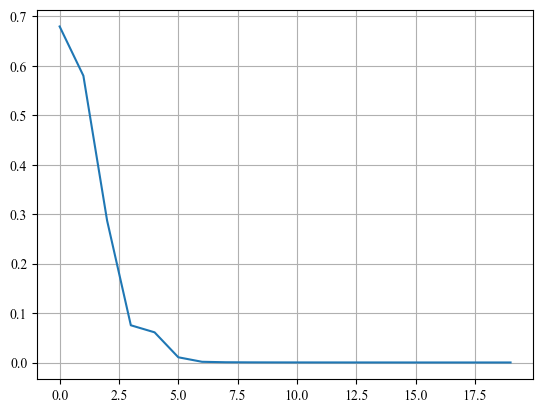

2009ml45_130km_30dias_v7_boots_hl_420_210_105_53_27_5_int0_scr1.0.joblib


In [142]:
letras = prefijo + '_v7_boots'
pathSave = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v7/'
# Propuesta de 4 estructuras considerando los 8 modelos anteriores
estuctura = [[420, 210, 105, 53, 27, 5]] # Misma que el Mod 7

scoreInteres = 0.9
intentos = 5
print(letras, '\n')
for hl in estuctura:
  print('---- ',hl)

  c = 0

  while c <= intentos:
    print('\n ', c)

    modelo_MLPClass = MLPClassifier(hidden_layer_sizes=tuple(hl),
                                    activation='relu', #identity, logistic, tanh, relu
                                    early_stopping=False,
                                    solver='adam',
                                    max_iter=30)#, random_state= 0)
    # Se entrena
    tinicio = time.perf_counter() # Segundos

    modelo_MLPClass.fit(X2021, y2021)

    tfinal = time.perf_counter() # Segundos
    tiempo = tfinal - tinicio

    print('Segundos empleados: ',tiempo)

    scoreMLPClass = modelo_MLPClass.score(X2021, y2021)
    print('Score: ', scoreMLPClass)

    plt.figure()
    plt.plot(np.arange(len(modelo_MLPClass.loss_curve_)),
            modelo_MLPClass.loss_curve_)
    plt.grid()
    plt.show()

    if scoreMLPClass >= scoreInteres:
      # guardar modelo
      Name = letras + f'_hl_{hl[0]}_{hl[1]}_{hl[2]}_{hl[3]}_{hl[4]}_{hl[5]}_int' + str(c) + '_scr' + str(round(scoreMLPClass, 3)) + '.joblib'
      dump(modelo_MLPClass, pathSave+Name)
      print(Name)
      break

    if c == intentos:
      print('Nada ...')
    c += 1

# Load model

In [143]:
modelo = '2009ml45_130km_30dias_v7_boots_hl_420_210_105_53_27_5_int0_scr1.0.joblib'

pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v7/'
modelo_P = load(pathModelos + modelo)
modelo_P

MLPClassifier(hidden_layer_sizes=(420, 210, 105, 53, 27, 5), max_iter=30)

# Plots

## Cambiar fuente

In [144]:
import matplotlib as mpl
import matplotlib.font_manager as fm

In [145]:
!wget https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

--2025-04-22 12:20:04--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-04-22 12:20:04--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf.1’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.06s   

2025-04-22 12:20:04 (13.9 MB/s) - ‘Times New Roman.ttf.1’ saved [834452/834452]



In [146]:
# Ruta a la fuente personalizada
font_path = 'Times New Roman.ttf'

# Añadir la fuente al administrador de fuentes de Matplotlib
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

# Nombre de la fuente para usar en rcParams
font_name = font_prop.get_name()
font_name

'Times New Roman'

In [147]:
import numpy as np
import matplotlib.pyplot as plt


In [148]:
plt.rcParams['font.family'] = font_name

## Confusion Matrix

In [150]:
Xtest = np.loadtxt(pathDatos + prefijo + '_X2023.txt')
ytest = np.loadtxt(pathDatos + prefijo + '_y2023.txt')
Xtrain = np.loadtxt(pathDatos + prefijo + '_X2022.txt')
ytrain = np.loadtxt(pathDatos + prefijo + '_y2022.txt')

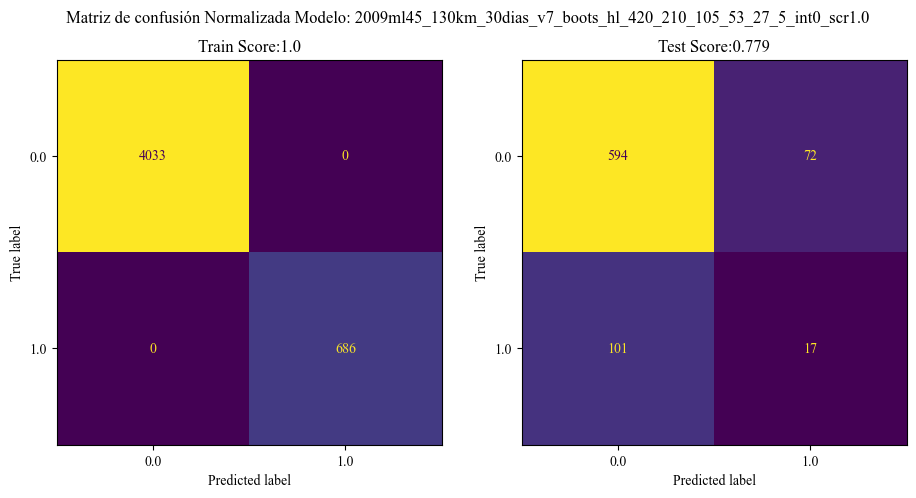

In [161]:
dictPuntajes = {'Modelo':[],
                'V':[],
                'Train_Score':[],
                'Train_TN':[],
                'Train_FP':[],
                'Train_FN':[],
                'Train_TP':[],
                'Test_Score':[],
                'Test_TN':[],
                'Test_FP':[],
                'Test_FN':[],
                'Test_TP':[]}
# Train
predichosModelo_Train = modelo_P.predict(Xtrain)
scoreTrain = np.round(modelo_P.score(Xtrain, ytrain), 3)
tn_Train, fp_Train, fn_Train, tp_Train = confusion_matrix(ytrain, predichosModelo_Train, normalize=None).ravel()

# Test
predichosModelo_Test = modelo_P.predict(Xtest)
accuracyScore_Test = np.round(accuracy_score(ytest, predichosModelo_Test),3)
tn_Test, fp_Test, fn_Test, tp_Test = confusion_matrix(ytest, predichosModelo_Test, normalize=None).ravel()

# Incluir en la lista
dictPuntajes['Modelo'].append(modelo[:-7])
dictPuntajes['V'].append('v5')
dictPuntajes['Train_Score'].append(scoreTrain)
dictPuntajes['Train_TN'].append(tn_Train)
dictPuntajes['Train_FP'].append(fp_Train)
dictPuntajes['Train_FN'].append(fn_Train)
dictPuntajes['Train_TP'].append(tp_Train)
dictPuntajes['Test_Score'].append(accuracyScore_Test)
dictPuntajes['Test_TN'].append(tn_Test)
dictPuntajes['Test_FP'].append(fp_Test)
dictPuntajes['Test_FN'].append(fn_Test)
dictPuntajes['Test_TP'].append(tp_Test)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
#Train

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytrain, predichosModelo_Train, normalize=None),
                        display_labels=modelo_P.classes_,
                        ).plot(ax=axs[0], colorbar=False)
axs[0].set_title(f'Train Score:{scoreTrain}')

#Test
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, predichosModelo_Test, normalize=None),
                    display_labels=modelo_P.classes_,
                    ).plot(ax=axs[1], colorbar=False)
axs[1].set_title(f'Test Score:{accuracyScore_Test}')

plt.suptitle(f'Matriz de confusión Normalizada Modelo: {modelo[:-7]}')

plt.savefig((pathSaveFiguras + f'v7_{modelo[:-7]}.png'),
        format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

plt.show()
print('\n')



In [162]:
df_V7 = pd.DataFrame.from_dict(dictPuntajes)
df_V7

,Modelo,V,Train_Score,Train_TN,Train_FP,Train_FN,Train_TP,Test_Score,Test_TN,Test_FP,Test_FN,Test_TP
0,2009ml45_130km_30dias_v7_boots_hl_420_210_105_...,v5,1.0,4033,0,0,686,0.779,594,72,101,17


In [163]:
df_V7['Test_Score'][0]

np.float64(0.779)

### Metricas

In [164]:
Sc = df_V7['Test_Score'][0].round(3)
TP = df_V7['Test_TP'][0].round(3)
FP = df_V7['Test_FP'][0].round(3)
R = np.round(df_V7['Test_TP'][0] / (df_V7['Test_TP'][0] + df_V7['Test_FN'][0]),3)
P = np.round(df_V7['Test_TP'][0] / (df_V7['Test_TP'][0] + df_V7['Test_FP'][0]),3)
F1 = np.round(( 2*df_V7['Test_TP'][0]) / (df_V7['Test_TP'][0] + df_V7['Test_FP'][0] + df_V7['Test_FN'][0]),3)

y_score = modelo_P.predict_proba(Xtest)[:,1]
AUC = roc_auc_score(ytest, y_score).round(3)

for i in [Sc, TP, FP, R, P, F1, AUC]:
  print(i)

0.779
17
72
0.144
0.191
0.179
0.586


## Time

In [165]:
X2023 = np.loadtxt(pathDatos + prefijo + '_X2023.txt')
y2023 = np.loadtxt(pathDatos + prefijo + '_y2023.txt')
X2022 = np.loadtxt(pathDatos + prefijo + '_X2022.txt')
y2022 = np.loadtxt(pathDatos + prefijo + '_y2022.txt')

In [166]:
labelModelo = 'Mod revision'

# 2023
predichosModelo = modelo_P.predict(X2023)
predProb_Modelo = modelo_P.predict_proba(X2023)[:,1]
# 1994-2023
#predichosModelo_2022 = modelo_P.predict(X2022)
predProb_Modelo_2022 = modelo_P.predict_proba(X2022)[:,1]

nMin = dias_Considerar - 1
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

fechas2023 = np.arange('2022-01-01', '2024-03-01', dtype='datetime64[D]')
fechas2023 = fechas2023[:-6]
# Sacar las fechas inicio fin de los rectangulos
fechaInicio = []
fechaFin = []

for i in range(0, len(y2023)-1):
  if (y2023[i] == 0) & (y2023[i+1] == 1):
    fechaInicio.append(fechas2023[i+1])
  if (y2023[i] == 1) & (y2023[i+1] == 0):
    fechaFin.append(fechas2023[i])
fechaInicio = np.array(fechaInicio).reshape(-1,1)
fechaFin = np.array(fechaFin).reshape(-1,1)
fechasRectangulo = np.concatenate((fechaInicio, fechaFin), axis=1)
fechasRectangulo

array([['2022-03-01', '2022-03-06'],
       ['2022-05-10', '2022-05-15'],
       ['2022-05-24', '2022-05-29'],
       ['2022-06-12', '2022-06-17'],
       ['2022-08-07', '2022-08-12'],
       ['2022-09-13', '2022-09-18'],
       ['2022-10-12', '2022-10-17'],
       ['2023-01-07', '2023-01-12'],
       ['2023-02-09', '2023-02-14'],
       ['2023-03-04', '2023-03-09'],
       ['2023-05-08', '2023-05-13'],
       ['2023-05-22', '2023-05-27'],
       ['2023-08-11', '2023-08-16'],
       ['2023-09-01', '2023-09-06'],
       ['2023-09-08', '2023-09-15'],
       ['2023-10-24', '2023-11-03'],
       ['2024-01-15', '2024-01-21'],
       ['2024-02-14', '2024-02-21']], dtype='datetime64[D]')

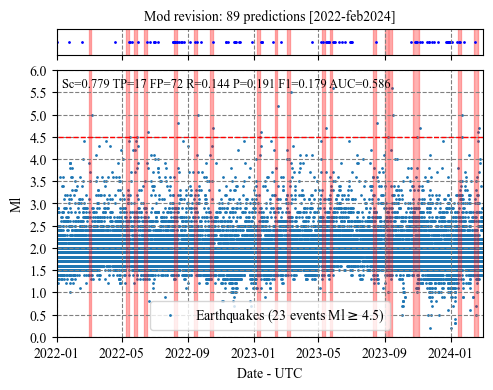

In [167]:
# Figuras 2023
fig, ax = plt.subplots(2,1, figsize=(5.5,4), sharex=True, gridspec_kw={'height_ratios': [1, 10]})

# Probabilidad
# Rectangulos
for rec in range(0, fechasRectangulo.shape[0]):
  deltaDias = fechasRectangulo[rec,1] - fechasRectangulo[rec,0]
  Xrec = fechasRectangulo[rec,0]
  Yrec = -1
  ax[0].add_patch(Rectangle(xy=(Xrec, Yrec),
                          width=(fechasRectangulo[rec,1] - fechasRectangulo[rec,0]),
                          height=10,
                          fill=True,
                          color ='red',
                          alpha=0.3)
                          )
predSis = ax[0].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][predichosModelo >= 1],
            predichosModelo[predichosModelo >= 1]*7,
            s= 1,
            c='b',
            label=f'Predicted: {int(sum(predichosModelo))}')
#ax[0].legend(loc=1, fontsize=10)

ax[0].set_ylim(6.5, 7.5)
#ax[0].set_ylabel('Probabilidad [%]', fontsize=10)
ax[0].set_yticks([])
#ax[0].set_xlabel('Fecha - UTC')
ax[0].grid(ls='--', color='grey')
ax[0].set_title(f'{labelModelo}: {int(sum(predichosModelo))} predictions [2022-feb2024]', fontsize=10)

# Eventos logrados
event4_5 = df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()]
event4_5 = event4_5 >= 4.5
event4_5 = sum(event4_5)



ax[1].scatter(df['Date-Time'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
              df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
              s=1,
              label=f'Earthquakes ({event4_5} events Ml$\geq$4.5)',
              c='tab:blue',
              alpha=1)

# Rectangulos
for rec in range(0, fechasRectangulo.shape[0]):
  deltaDias = fechasRectangulo[rec,1] - fechasRectangulo[rec,0]
  Xrec = fechasRectangulo[rec,0]
  Yrec = -1
  ax[1].add_patch(Rectangle(xy=(Xrec, Yrec),
                          width=(fechasRectangulo[rec,1] - fechasRectangulo[rec,0]),
                          height=8,
                          fill=True,
                          color ='red',
                          alpha=0.3)
                          )

left, right = plt.xlim()
ax[1].hlines(y= 4.5,
            xmin=left,
            xmax=right,
            ls='--',
            lw=1,
            color='r',)
#label='Q1={}'.format(Q1))

ax[1].set_ylim(-0.5, 7.5)
ax[1].set_ylabel('Ml', fontsize=10)
ax[1].set_xlabel('Date - UTC', fontsize=10)
ax[1].grid(ls='--', color='grey')
ax[1].set_yticks(np.arange(0, 8, 0.5))
ax[1].set_ylim(0,6)
ax[1].legend(loc=8, fontsize=10)

textoModelo = f'Sc={Sc} TP={TP} FP={FP} R={R} P={P} F1={F1} AUC={AUC}'
ax[1].text(x= np.datetime64('2022-01-10'),
           y= 5.5 + 0.1,
           s= textoModelo,
           fontsize=9)

plt.subplots_adjust(hspace=0.1)
plt.xticks(np.arange(np.datetime64("2022-01-01"), np.datetime64("2024-03-01"),  np.timedelta64(4, 'M'), dtype='datetime64[M]'),
            labels=np.arange(np.datetime64("2022-01-01"), np.datetime64("2024-03-01"),  np.timedelta64(4, 'M'), dtype='datetime64[M]'))

plt.xlim(np.datetime64('2022-01-01'), np.datetime64('2024-03-01'))
plt.tick_params(labelsize=10)

#plt.tight_layout()
plt.savefig((pathSaveFiguras + f'2022_{labelModelo}.png'),
            format='png', dpi=1000, bbox_inches = 'tight',pad_inches=0.25)

plt.show()

print('\n')

# End